In [ ]:
# 필수로 먼저 실행하기
!pip install ortools plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 6.31.1 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.31.1 which is incom

In [ ]:
from ortools.sat.python import cp_model
from itertools import permutations
import random
import plotly.graph_objects as go
import matplotlib.colors as mcolors

In [ ]:
# 사용 가능한 상자 리스트 (mm 단위로 변환)
boxes = [
    {"name": "1-1호", "size": (165, 110, 50), "price": 600},
    {"name": "1호", "size": (220, 190, 90), "price": 700},
    {"name": "2호", "size": (270, 180, 150), "price": 800},
    {"name": "2-1호", "size": (350, 250, 100), "price": 900},
    {"name": "3호", "size": (340, 250, 210), "price": 1100},
    {"name": "4호", "size": (410, 310, 280), "price": 1700},
    {"name": "5호", "size": (480, 360, 340), "price": 2300},
]

# 아이템 생성 함수 (mm 단위)
def generate_items(n=10, min_dim=50, max_dim=120):
    items = []
    for i in range(n):
        w, d, h = [random.randint(min_dim, max_dim) for _ in range(3)]
        items.append({"name": f"Item{i+1}", "size": (w, d, h)})
    return items

items = generate_items()

# CP-SAT 기반 최적화 함수
def solve_cp_sat_packing(box_size, items):
    model = cp_model.CpModel()
    n = len(items)
    max_x, max_y, max_z = box_size

    def rotations(w, d, h):
        return list(set(permutations([w, d, h])))

    x = [model.NewIntVar(0, max_x, f'x_{i}') for i in range(n)]
    y = [model.NewIntVar(0, max_y, f'y_{i}') for i in range(n)]
    z = [model.NewIntVar(0, max_z, f'z_{i}') for i in range(n)]
    o = [model.NewIntVar(0, 5, f'o_{i}') for i in range(n)]

    orientations = [rotations(*item["size"]) for item in items]

    w_vars, d_vars, h_vars = [], [], []
    for i in range(n):
        wv = model.NewIntVar(0, max_x, f'w_{i}')
        dv = model.NewIntVar(0, max_y, f'd_{i}')
        hv = model.NewIntVar(0, max_z, f'h_{i}')
        perms = list(zip(*orientations[i]))
        model.AddElement(o[i], list(perms[0]), wv)
        model.AddElement(o[i], list(perms[1]), dv)
        model.AddElement(o[i], list(perms[2]), hv)
        w_vars.append(wv)
        d_vars.append(dv)
        h_vars.append(hv)

    for i in range(n):
        model.Add(x[i] + w_vars[i] <= max_x)
        model.Add(y[i] + d_vars[i] <= max_y)
        model.Add(z[i] + h_vars[i] <= max_z)

    for i in range(n):
        for j in range(i + 1, n):
            conds = [
                model.NewBoolVar(f'left_{i}_{j}'),
                model.NewBoolVar(f'right_{i}_{j}'),
                model.NewBoolVar(f'front_{i}_{j}'),
                model.NewBoolVar(f'back_{i}_{j}'),
                model.NewBoolVar(f'below_{i}_{j}'),
                model.NewBoolVar(f'above_{i}_{j}')
            ]
            model.Add(x[i] + w_vars[i] <= x[j]).OnlyEnforceIf(conds[0])
            model.Add(x[j] + w_vars[j] <= x[i]).OnlyEnforceIf(conds[1])
            model.Add(y[i] + d_vars[i] <= y[j]).OnlyEnforceIf(conds[2])
            model.Add(y[j] + d_vars[j] <= y[i]).OnlyEnforceIf(conds[3])
            model.Add(z[i] + h_vars[i] <= z[j]).OnlyEnforceIf(conds[4])
            model.Add(z[j] + h_vars[j] <= z[i]).OnlyEnforceIf(conds[5])
            model.AddBoolOr(conds)

    model.Minimize(sum(z))
    solver = cp_model.CpSolver()
    solver.parameters.num_search_workers = 0
    status = solver.Solve(model)

    if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        result = []
        for i in range(n):
            dims = orientations[i][solver.Value(o[i])]
            pos = (solver.Value(x[i]), solver.Value(y[i]), solver.Value(z[i]))
            result.append({"name": items[i]["name"], "size": dims, "position": pos})
        return result
    return None

# Plotly 기반 3D 시각화 함수 (직육면체를 12개의 삼각형으로 표현)
def draw_3d_plotly(container_size, packed_items):
    colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
    fig = go.Figure()

    for i, item in enumerate(packed_items):
        x0, y0, z0 = item["position"]
        dx, dy, dz = item["size"]
        color = colors[i % len(colors)]

        # 8개 꼭짓점
        vertices = [
            [x0,     y0,     z0],     # 0
            [x0+dx,  y0,     z0],     # 1
            [x0+dx,  y0+dy,  z0],     # 2
            [x0,     y0+dy,  z0],     # 3
            [x0,     y0,     z0+dz],  # 4
            [x0+dx,  y0,     z0+dz],  # 5
            [x0+dx,  y0+dy,  z0+dz],  # 6
            [x0,     y0+dy,  z0+dz],  # 7
        ]
        x, y, z = zip(*vertices)

        # 12개 삼각형 인덱스
        i_idx = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
        j_idx = [1, 3, 2, 5, 3, 6, 0, 7, 5, 7, 6, 4]
        k_idx = [2, 2, 6, 6, 7, 7, 4, 4, 1, 3, 2, 0]

        fig.add_trace(go.Mesh3d(
            x=x, y=y, z=z,
            i=i_idx, j=j_idx, k=k_idx,
            color=color,
            opacity=0.6,
            showscale=False,
            flatshading=True
        ))

    fig.update_layout(
        scene=dict(
            xaxis_title='x',
            yaxis_title='y',
            zaxis_title='z',
            xaxis=dict(range=[0, container_size[0]]),
            yaxis=dict(range=[0, container_size[1]]),
            zaxis=dict(range=[0, container_size[2]])
        ),
        title="CP-SAT 기반 3D 박스 배치 결과 (Plotly - 직육면체)"
    )
    fig.show()

# 상자 선택 및 실행
def try_packing():
    for box in boxes:
        print(f"\n🧪 {box['name']} 상자 시도 중...")
        solution = solve_cp_sat_packing(box['size'], items)
        if solution:
            print(f"✅ {box['name']} 상자에 배치 성공!")
            draw_3d_plotly(box['size'], solution)
            return
    print("❌ 어떤 상자에도 모든 아이템을 배치할 수 없습니다.")

# 실행
try_packing()


🧪 1-1호 상자 시도 중...

🧪 1호 상자 시도 중...

🧪 2호 상자 시도 중...
✅ 2호 상자에 배치 성공!


In [ ]:
import random
from ortools.sat.python import cp_model
from itertools import permutations
import plotly.graph_objects as go
import matplotlib.colors as mcolors

# 박스 정의 (mm 단위)
BOXES = {
    "3호": (340, 250, 210),
    "4호": (410, 310, 280),
    "5호": (480, 360, 340),
}

# CP-SAT 3D packing 함수
def solve_pack(box_size, items, time_limit=2):
    W, D, H = box_size
    n = len(items)
    model = cp_model.CpModel()

    x = [model.NewIntVar(0, W, f'x{i}') for i in range(n)]
    y = [model.NewIntVar(0, D, f'y{i}') for i in range(n)]
    z = [model.NewIntVar(0, H, f'z{i}') for i in range(n)]
    o = [model.NewIntVar(0, 5,    f'o{i}') for i in range(n)]
    inc = [model.NewBoolVar(f'inc{i}') for i in range(n)]

    oris = [list(dict.fromkeys(permutations(it["size"], 3))) for it in items]

    wv, dv, hv = [], [], []
    for i in range(n):
        wvar = model.NewIntVar(0, W, f'w{i}')
        dvar = model.NewIntVar(0, D, f'd{i}')
        hvar = model.NewIntVar(0, H, f'h{i}')
        allowed = [(r, *ori) for r, ori in enumerate(oris[i])]
        model.AddAllowedAssignments([o[i], wvar, dvar, hvar], allowed)
        wv.append(wvar); dv.append(dvar); hv.append(hvar)

    # 경계 제약
    for i in range(n):
        model.Add(x[i] + wv[i] <= W).OnlyEnforceIf(inc[i])
        model.Add(y[i] + dv[i] <= D).OnlyEnforceIf(inc[i])
        model.Add(z[i] + hv[i] <= H).OnlyEnforceIf(inc[i])

    # 비중첩
    for i in range(n):
        for j in range(i+1, n):
            b = [model.NewBoolVar(f'b{i}{j}{k}') for k in range(6)]
            model.Add(x[i] + wv[i] <= x[j]).OnlyEnforceIf([inc[i], inc[j], b[0]])
            model.Add(x[j] + wv[j] <= x[i]).OnlyEnforceIf([inc[i], inc[j], b[1]])
            model.Add(y[i] + dv[i] <= y[j]).OnlyEnforceIf([inc[i], inc[j], b[2]])
            model.Add(y[j] + dv[j] <= y[i]).OnlyEnforceIf([inc[i], inc[j], b[3]])
            model.Add(z[i] + hv[i] <= z[j]).OnlyEnforceIf([inc[i], inc[j], b[4]])
            model.Add(z[j] + hv[j] <= z[i]).OnlyEnforceIf([inc[i], inc[j], b[5]])
            model.AddBoolOr(b).OnlyEnforceIf([inc[i], inc[j]])

    # 목표: 최대 담기
    model.Maximize(sum(inc))

    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = time_limit
    stat = solver.Solve(model)

    packed, leftover = [], []
    if stat in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        for i in range(n):
            if solver.Value(inc[i]):
                r = solver.Value(o[i])
                packed.append({
                    "name": items[i]["name"],
                    "size": oris[i][r],
                    "position": (
                        solver.Value(x[i]), solver.Value(y[i]), solver.Value(z[i])
                    )
                })
            else:
                leftover.append(items[i])
    else:
        leftover = items[:]

    return packed, leftover

# 3D 아이템 시각화
def draw_items(box_size, packed, title):
    W, D, H = box_size
    vol_used = sum(dx*dy*dz for it in packed for dx, dy, dz in [it["size"]])
    fill_rate = vol_used / (W * D * H)
    title = f"{title} — Fill Rate: {fill_rate:.3f}"

    I = [0,0,1,1,2,2,3,3,4,4,5,5]
    J = [1,3,2,5,3,6,0,7,5,7,6,4]
    K = [2,2,6,6,7,7,4,4,1,3,2,0]
    colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
    fig = go.Figure()
    for idx, it in enumerate(packed):
        x0, y0, z0 = it["position"]
        dx, dy, dz = it["size"]
        verts = [
            [x0, y0, z0], [x0+dx, y0, z0], [x0+dx, y0+dy, z0], [x0, y0+dy, z0],
            [x0, y0, z0+dz], [x0+dx, y0, z0+dz], [x0+dx, y0+dy, z0+dz], [x0, y0+dy, z0+dz],
        ]
        xs, ys, zs = zip(*verts)
        fig.add_trace(go.Mesh3d(
            x=xs, y=ys, z=zs, i=I, j=J, k=K,
            color=colors[idx % len(colors)], opacity=0.7, flatshading=True, showscale=False
        ))
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(range=[0, W], title=f"X(0–{W})"),
            yaxis=dict(range=[0, D], title=f"Y(0–{D})"),
            zaxis=dict(range=[0, H], title=f"Z(0–{H})"),
            aspectmode="data"
        ),
        margin=dict(l=0, r=0, b=0, t=30)
    )
    fig.show()

# 랜덤 아이템 생성 후 조건 만족할 때까지 반복
def find_high_fill_set():
    attempt = 0
    while True:
        attempt += 1
        # 8~12개 아이템 무작위 생성 (치수 80~200 범위)
        n = random.randint(8, 12)
        items = [{"name":f"Item{i+1}", "size":(
            random.randint(80,200),
            random.randint(80,200),
            random.randint(80,200)
        )} for i in range(n)]

        # Case1: 4호 → 4호
        packed1, rem1 = solve_pack(BOXES["4호"], items)
        vol1 = sum(dx*dy*dz for it in packed1 for dx,dy,dz in [it["size"]]) / (410*310*280)
        if not rem1: continue  # 남은 아이템 반드시 있어야 둘 다 평가
        packed2, rem2 = solve_pack(BOXES["4호"], rem1)
        vol2 = sum(dx*dy*dz for it in packed2 for dx,dy,dz in [it["size"]]) / (410*310*280)

        if vol1>=0.8 and vol2>=0.8:
            print(f"Found on attempt {attempt}: n={n}, vol1={vol1:.3f}, vol2={vol2:.3f}")
            return items, packed1, packed2

# 실행
items, p1, p2 = find_high_fill_set()
print("Items:", [it["size"] for it in items])

# 시각화
draw_items(BOXES["4호"], p1, "Case1: 4호 (1st)")
draw_items(BOXES["4호"], p2, "Case1: 4호 (2nd)")


4호4호 vs 3호5호 최종 코드

In [ ]:
# Colab 환경에서 실행 가능한 전체 코드 (40개 아이템 + full-support)

from ortools.sat.python import cp_model
from itertools import permutations
import plotly.graph_objects as go
import matplotlib.colors as mcolors

# 1) 상자 정의 (mm 단위)
BOXES = {
    "3호": (340, 250, 210),
    "4호": (410, 310, 280),
    "5호": (480, 360, 340),
}
BOX_VOL = {k: v[0]*v[1]*v[2] for k,v in BOXES.items()}

# 2) CP-SAT 3D packing 함수 (full-support)
def solve_pack(box_size, items, time_limit=10):
    W,D,H = box_size
    n = len(items)
    model = cp_model.CpModel()

    # 변수 생성
    x = [model.NewIntVar(0, W, f'x{i}')    for i in range(n)]
    y = [model.NewIntVar(0, D, f'y{i}')    for i in range(n)]
    z = [model.NewIntVar(0, H, f'z{i}')    for i in range(n)]
    o = [model.NewIntVar(0, 5, f'o{i}')    for i in range(n)]
    inc = [model.NewBoolVar(   f'inc{i}') for i in range(n)]

    # 6가지 회전 준비
    oris = []
    for it in items:
        s = list(dict.fromkeys(permutations(it["size"],3)))
        while len(s)<6: s.append(s[-1])
        oris.append(s)

    # w,d,h 변수 & o 연결
    wv,dv,hv = [],[],[]
    for i in range(n):
        w_i = model.NewIntVar(0,W,f'w{i}')
        d_i = model.NewIntVar(0,D,f'd{i}')
        h_i = model.NewIntVar(0,H,f'h{i}')
        # o[i],w_i,d_i,h_i 는 oris[i][o[i]]
        allowed = [(r,*oris[i][r]) for r in range(6)]
        model.AddAllowedAssignments([o[i],w_i,d_i,h_i], allowed)
        wv.append(w_i); dv.append(d_i); hv.append(h_i)

    # 2-1) 경계 제약
    for i in range(n):
        model.Add(x[i]+wv[i] <= W).OnlyEnforceIf(inc[i])
        model.Add(y[i]+dv[i] <= D).OnlyEnforceIf(inc[i])
        model.Add(z[i]+hv[i] <= H).OnlyEnforceIf(inc[i])

    # 2-2) 비중첩 제약
    for i in range(n):
        for j in range(i+1,n):
            b = [model.NewBoolVar(f'b_{i}_{j}_{k}') for k in range(6)]
            model.Add(x[i]+wv[i] <= x[j]).OnlyEnforceIf([inc[i],inc[j],b[0]])
            model.Add(x[j]+wv[j] <= x[i]).OnlyEnforceIf([inc[i],inc[j],b[1]])
            model.Add(y[i]+dv[i] <= y[j]).OnlyEnforceIf([inc[i],inc[j],b[2]])
            model.Add(y[j]+dv[j] <= y[i]).OnlyEnforceIf([inc[i],inc[j],b[3]])
            model.Add(z[i]+hv[i] <= z[j]).OnlyEnforceIf([inc[i],inc[j],b[4]])
            model.Add(z[j]+hv[j] <= z[i]).OnlyEnforceIf([inc[i],inc[j],b[5]])
            model.AddBoolOr(b).OnlyEnforceIf([inc[i],inc[j]])

    # 2-3) full-support 제약
    sup = {}
    for i in range(n):
        ground = model.NewBoolVar(f'sup_{i}_ground')
        sup[(i,-1)] = ground
        # 바닥 지지 → z=0
        model.Add(z[i]==0).OnlyEnforceIf(ground)
        for j in range(n):
            if i==j: continue
            sij = model.NewBoolVar(f'sup_{i}_{j}')
            sup[(i,j)] = sij
            # 지지 조건
            model.AddImplication(sij, inc[i])
            model.AddImplication(sij, inc[j])
            model.Add(z[i] == z[j] + hv[j]).OnlyEnforceIf(sij)
            model.Add(x[i]   >= x[j]).OnlyEnforceIf(sij)
            model.Add(x[i]+wv[i] <= x[j]+wv[j]).OnlyEnforceIf(sij)
            model.Add(y[i]   >= y[j]).OnlyEnforceIf(sij)
            model.Add(y[i]+dv[i] <= y[j]+dv[j]).OnlyEnforceIf(sij)
        # 반드시 한 곳에서 지지
        model.Add(
            sum(sup[(i,k)] for k in [-1,*range(n)] if k!=i) == inc[i]
        )

    # 3) 목적: 최대 아이템 개수
    model.Maximize(sum(inc))

    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = time_limit
    status = solver.Solve(model)

    packed, leftover = [], []
    if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        for i in range(n):
            if solver.Value(inc[i]):
                r = solver.Value(o[i])
                packed.append({
                    "name": items[i]["name"],
                    "size": oris[i][r],
                    "position": (
                        solver.Value(x[i]),
                        solver.Value(y[i]),
                        solver.Value(z[i])
                    )
                })
            else:
                leftover.append(items[i])
    else:
        leftover = items[:]
    return packed, leftover

# 3) 3D 시각화 (흰색 제외)
def draw_items(box_size, packed, title):
    W,D,H = box_size
    I=[0,0,1,1,2,2,3,3,4,4,5,5]
    J=[1,3,2,5,3,6,0,7,5,7,6,4]
    K=[2,2,6,6,7,7,4,4,1,3,2,0]
    allc = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
    lum = lambda c: sum(w*ch for w,ch in zip((0.2126,0.7152,0.0722), mcolors.to_rgb(c)))
    pal = [c for c in allc if lum(c)<=0.8]
    fig = go.Figure()
    for idx,it in enumerate(packed):
        x0,y0,z0 = it["position"]
        dx,dy,dz = it["size"]
        V = [
            [x0,y0,z0],[x0+dx,y0,z0],[x0+dx,y0+dy,z0],[x0,y0+dy,z0],
            [x0,y0,z0+dz],[x0+dx,y0,z0+dz],[x0+dx,y0+dy,z0+dz],[x0,y0+dy,z0+dz]
        ]
        xs,ys,zs = zip(*V)
        fig.add_trace(go.Mesh3d(
            x=xs,y=ys,z=zs,i=I,j=J,k=K,
            color=pal[idx%len(pal)],opacity=0.7,flatshading=True,showscale=False,
            name=it["name"]
        ))
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(range=[0,W],title=f"X 0–{W}"),
            yaxis=dict(range=[0,D],title=f"Y 0–{D}"),
            zaxis=dict(range=[0,H],title=f"Z 0–{H}"),
            aspectmode="data"
        ),
        margin=dict(l=0,r=0,b=0,t=30)
    )
    fig.show()

# 4) 메인: raw_cm 교체 후 실행
if __name__=="__main__":
    raw_cm = [
        (12,14,13),(12,8,13),(12,8,13),(10,6,13),(14,6,13),
        (8,14,13),(10,8,13),(10,8,13),(12,12,13),(12,8,13),
        (4,20,13),(14,18,13),(18,8,13),(10,12,13),(10,10,13),
        (8,20,13),(16,10,13),(12,14,13),(12,8,13),(12,8,13),
        (10,6,13),(14,6,13),(8,14,13),(10,8,13),(10,8,13),
        (12,12,13),(12,8,13),(4,20,13),(14,18,13),(18,8,13),
        (10,12,13),(10,10,13),(8,20,13),(16,10,13)
    ]
    # cm → mm 변환
    items = [
        {"name":f"Item{i+1}", "size":(x*10,y*10,z*10)}
        for i,(x,y,z) in enumerate(raw_cm)
    ]

    cases = [("4호","4호"),("3호","5호")]
    for idx,(b1,b2) in enumerate(cases,1):
        print(f"\n=== CASE{idx}: {b1} → {b2} ===")
        p1, rem1 = solve_pack(BOXES[b1], items)
        print(f"1st({b1}): 담긴={len(p1)}, 남은={len(rem1)}")
        draw_items(BOXES[b1], p1, f"{b1} (1st)")
        p2, rem2 = solve_pack(BOXES[b2], rem1)
        print(f"2nd({b2}): 담긴={len(p2)}, 최종남은={len(rem2)}")
        draw_items(BOXES[b2], p2, f"{b2} (2nd)")
        vol = sum(dx*dy*dz for it in (*p1,*p2) for dx,dy,dz in [it["size"]])
        denom = 2*BOX_VOL[b1] if b1==b2 else BOX_VOL[b1]+BOX_VOL[b2]
        print(f"▶ FillRate(case{idx}) = {vol/denom:.3f}")



=== CASE1: 4호 → 4호 ===
1st(4호): 담긴=17, 남은=17


2nd(4호): 담긴=17, 최종남은=0


▶ FillRate(case1) = 0.742

=== CASE2: 3호 → 5호 ===
1st(3호): 담긴=12, 남은=22


2nd(5호): 담긴=22, 최종남은=0


▶ FillRate(case2) = 0.690


In [ ]:
# Colab 환경에서 실행 가능한 전체 코드 (버림 → mm 변환)

# 필요한 라이브러리 설치 (필요시)
# !pip install ortools plotly --quiet

from ortools.sat.python import cp_model
from itertools import permutations
import plotly.graph_objects as go
import matplotlib.colors as mcolors
import math

# ——————————————————————————————————————————————————————————
# 1) 상자 정의 (mm 단위)
# ——————————————————————————————————————————————————————————
boxes = [
    {"name": "1-1호", "size": (165, 110,  50), "price":  600},
    {"name": "1호",   "size": (220, 190,  90), "price":  700},
    {"name": "2호",   "size": (270, 180, 150), "price":  800},
    {"name": "2-1호", "size": (350, 250, 100), "price":  900},
    {"name": "3호",   "size": (340, 250, 210), "price": 1100},
    {"name": "4호",   "size": (410, 310, 280), "price": 1700},
    {"name": "5호",   "size": (480, 360, 340), "price": 2300},
]

# ——————————————————————————————————————————————————————————
# 2) 실제 5개 아이템 정의 (cm → 버림 → mm 변환)
# ——————————————————————————————————————————————————————————
raw_cm = [
    ("초코하임",   20.5, 14.0,  4.0),
    ("초코칩쿠키", 21.0,  8.5,  4.0),
    ("야채크래커", 22.5,  5.5,  5.5),
    ("크라운산도", 18.0, 14.0,  6.0),
    ("오예쓰",     23.5, 21.0,  5.5),
]
items = []
for name, x_cm, y_cm, z_cm in raw_cm:
    x_mm = math.floor(x_cm) * 10
    y_mm = math.floor(y_cm) * 10
    z_mm = math.floor(z_cm) * 10
    items.append({"name": name, "size": (x_mm, y_mm, z_mm)})

# ——————————————————————————————————————————————————————————
# 3) CP-SAT 3D Packing (Full-support + maximize count)
# ——————————————————————————————————————————————————————————
def solve_cp_sat_packing(box_size, items, time_limit=10):
    W, D, H = box_size
    n = len(items)
    model = cp_model.CpModel()

    # 변수 정의
    x   = [model.NewIntVar(0, W, f'x{i}')    for i in range(n)]
    y   = [model.NewIntVar(0, D, f'y{i}')    for i in range(n)]
    z   = [model.NewIntVar(0, H, f'z{i}')    for i in range(n)]
    o   = [model.NewIntVar(0, 5, f'o{i}')    for i in range(n)]
    inc = [model.NewBoolVar(f'inc{i}')       for i in range(n)]

    # 6가지 회전 조합 준비
    oris = []
    for it in items:
        perms = list(dict.fromkeys(permutations(it["size"], 3)))
        while len(perms) < 6:
            perms.append(perms[-1])
        oris.append(perms)

    # wv,dv,hv 변수 및 회전 매핑
    wv, dv, hv = [], [], []
    for i in range(n):
        w_i = model.NewIntVar(0, W, f'w{i}')
        d_i = model.NewIntVar(0, D, f'd{i}')
        h_i = model.NewIntVar(0, H, f'h{i}')
        allowed = [(r, *oris[i][r]) for r in range(6)]
        model.AddAllowedAssignments([o[i], w_i, d_i, h_i], allowed)
        wv.append(w_i); dv.append(d_i); hv.append(h_i)

    # 경계 제약 (inc=True 일 때만 적용)
    for i in range(n):
        model.Add(x[i] + wv[i] <= W).OnlyEnforceIf(inc[i])
        model.Add(y[i] + dv[i] <= D).OnlyEnforceIf(inc[i])
        model.Add(z[i] + hv[i] <= H).OnlyEnforceIf(inc[i])

    # 비중첩 제약
    for i in range(n):
        for j in range(i+1, n):
            b = [model.NewBoolVar(f'b_{i}_{j}_{k}') for k in range(6)]
            model.Add(x[i] + wv[i] <= x[j]).OnlyEnforceIf([inc[i], inc[j], b[0]])
            model.Add(x[j] + wv[j] <= x[i]).OnlyEnforceIf([inc[i], inc[j], b[1]])
            model.Add(y[i] + dv[i] <= y[j]).OnlyEnforceIf([inc[i], inc[j], b[2]])
            model.Add(y[j] + dv[j] <= y[i]).OnlyEnforceIf([inc[i], inc[j], b[3]])
            model.Add(z[i] + hv[i] <= z[j]).OnlyEnforceIf([inc[i], inc[j], b[4]])
            model.Add(z[j] + hv[j] <= z[i]).OnlyEnforceIf([inc[i], inc[j], b[5]])
            model.AddBoolOr(b).OnlyEnforceIf([inc[i], inc[j]])

    # Full-support 제약
    for i in range(n):
        g = model.NewBoolVar(f'sup_{i}_floor')
        model.Add(z[i] == 0).OnlyEnforceIf(g)
        model.Add(g <= inc[i])
        sup_vars = [g]
        for j in range(n):
            if i == j: continue
            s = model.NewBoolVar(f'sup_{i}_{j}')
            sup_vars.append(s)
            model.Add(s <= inc[i])
            model.Add(s <= inc[j])
            model.Add(z[i] == z[j] + hv[j]).OnlyEnforceIf(s)
            model.Add(x[i]   >= x[j]).OnlyEnforceIf(s)
            model.Add(x[i]+wv[i] <= x[j]+wv[j]).OnlyEnforceIf(s)
            model.Add(y[i]   >= y[j]).OnlyEnforceIf(s)
            model.Add(y[i]+dv[i] <= y[j]+dv[j]).OnlyEnforceIf(s)
        model.Add(sum(sup_vars) == inc[i])

    # 목표: 담은 아이템 수 최대화
    model.Maximize(sum(inc))

    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = time_limit
    status = solver.Solve(model)

    packed = []
    if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        for i in range(n):
            if solver.Value(inc[i]):
                r = solver.Value(o[i])
                packed.append({
                    "name":     items[i]["name"],
                    "size":     oris[i][r],
                    "position": (solver.Value(x[i]), solver.Value(y[i]), solver.Value(z[i]))
                })
    return packed

# ——————————————————————————————————————————————————————————
# 4) 3D 시각화 (Plotly, 흰색계열 제외)
# ——————————————————————————————————————————————————————————
def draw_3d_plotly(box_size, packed_items, title=""):
    W, D, H = box_size

    # 컨테이너와 아이템 모두에 쓸 삼각형 인덱스
    I = [0,0,1,1,2,2,3,3,4,4,5,5]
    J = [1,3,2,5,3,6,0,7,5,7,6,4]
    K = [2,2,6,6,7,7,4,4,1,3,2,0]

    # 밝은 흰색 계열을 제외한 컬러 팔레트
    allc = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
    def lum(c): return sum(w*x for w,x in zip((0.21,0.72,0.07), mcolors.to_rgb(c)))
    pal = [c for c in allc if lum(c) < 0.8]

    fig = go.Figure()

    # 1) 컨테이너 Mesh: 투명한 흐린 회색으로 먼저 그리기
    container_verts = [
        [0, 0, 0], [W, 0, 0], [W, D, 0], [0, D, 0],
        [0, 0, H], [W, 0, H], [W, D, H], [0, D, H]
    ]
    x_c, y_c, z_c = zip(*container_verts)
    fig.add_trace(go.Mesh3d(
        x=x_c, y=y_c, z=z_c,
        i=I, j=J, k=K,
        color="lightgray",
        opacity=0.1,
        flatshading=True,
        showscale=False,
        name="Container",
        showlegend=True
    ))

    # 2) 아이템 Mesh: 서로 다른 색상으로
    for idx, it in enumerate(packed_items):
        x0, y0, z0 = it["position"]
        dx, dy, dz = it["size"]
        verts = [
            [x0,     y0,     z0],     [x0+dx,  y0,     z0],
            [x0+dx,  y0+dy,  z0],     [x0,     y0+dy,  z0],
            [x0,     y0,     z0+dz],  [x0+dx,  y0,     z0+dz],
            [x0+dx,  y0+dy,  z0+dz],  [x0,     y0+dy,  z0+dz],
        ]
        xs, ys, zs = zip(*verts)
        fig.add_trace(go.Mesh3d(
            x=xs, y=ys, z=zs,
            i=I, j=J, k=K,
            color=pal[idx % len(pal)],
            opacity=0.7,
            flatshading=True,
            showscale=False,
            name=it["name"],
            showlegend=True
        ))

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(range=[0, W], title=f"X (0–{W}mm)"),
            yaxis=dict(range=[0, D], title=f"Y (0–{D}mm)"),
            zaxis=dict(range=[0, H], title=f"Z (0–{H}mm)"),
            aspectmode="data"
        ),
        legend=dict(
            title="Objects",
            orientation="h",
            yanchor="bottom", y=1.02,
            xanchor="center",  x=1
        ),
        margin=dict(l=0, r=0, b=0, t=30)
    )
    fig.show()

# ——————————————————————————————————————————————————————————
# 5) 실행: 가장 작은 박스부터 시도
# ——————————————————————————————————————————————————————————
def try_packing():
    for box in boxes:
        packed = solve_cp_sat_packing(box["size"], items)
        if len(packed) == len(items):
            print(f"✅ {box['name']}에 5개 모두 배치 성공!")
            draw_3d_plotly(box["size"], packed, title=f"{box['name']} Packing")
            return
    print("❌ 어떤 박스에도 5개 아이템을 모두 넣지 못했습니다.")

if __name__ == "__main__":
    try_packing()


✅ 2-1호에 5개 모두 배치 성공!


In [ ]:
# Colab 환경에서 실행 가능한 전체 코드 (버림 → mm 변환 + Fill Rate 계산)

# 필요한 라이브러리 설치 (필요시)
# !pip install ortools plotly --quiet

from ortools.sat.python import cp_model
from itertools import permutations
import plotly.graph_objects as go
import matplotlib.colors as mcolors
import math

# ——————————————————————————————————————————————————————————
# 1) 상자 정의 (mm 단위)
# ——————————————————————————————————————————————————————————
boxes = [
    {"name": "1-1호", "size": (165, 110,  50), "price":  600},
    {"name": "1호",   "size": (220, 190,  90), "price":  700},
    {"name": "2호",   "size": (270, 180, 150), "price":  800},
    {"name": "2-1호", "size": (350, 250, 100), "price":  900},
    {"name": "3호",   "size": (340, 250, 210), "price": 1100},
    {"name": "4호",   "size": (410, 310, 280), "price": 1700},
    {"name": "5호",   "size": (480, 360, 340), "price": 2300},
]

# ——————————————————————————————————————————————————————————
# 2) 실제 5개 아이템 정의 (cm → 버림 → mm 변환)
# ——————————————————————————————————————————————————————————
raw_cm = [
    ("초코하임",   20.5, 14.0,  4.0),
    ("초코칩쿠키", 21.0,  8.5,  4.0),
    ("야채크래커", 22.5,  5.5,  5.5),
    ("크라운산도", 18.0, 14.0,  6.0),
    ("오예쓰",     23.5, 21.0,  5.5),
]
items = []
for name, x_cm, y_cm, z_cm in raw_cm:
    x_mm = math.floor(x_cm) * 10
    y_mm = math.floor(y_cm) * 10
    z_mm = math.floor(z_cm) * 10
    items.append({"name": name, "size": (x_mm, y_mm, z_mm)})

# ——————————————————————————————————————————————————————————
# 3) CP-SAT 3D Packing (Full-support + maximize count)
# ——————————————————————————————————————————————————————————
def solve_cp_sat_packing(box_size, items, time_limit=10):
    W, D, H = box_size
    n = len(items)
    model = cp_model.CpModel()

    # 변수 정의
    x   = [model.NewIntVar(0, W, f'x{i}')    for i in range(n)]
    y   = [model.NewIntVar(0, D, f'y{i}')    for i in range(n)]
    z   = [model.NewIntVar(0, H, f'z{i}')    for i in range(n)]
    o   = [model.NewIntVar(0, 5, f'o{i}')    for i in range(n)]
    inc = [model.NewBoolVar(f'inc{i}')       for i in range(n)]

    # 6가지 회전 조합 준비
    oris = []
    for it in items:
        perms = list(dict.fromkeys(permutations(it["size"], 3)))
        while len(perms) < 6:
            perms.append(perms[-1])
        oris.append(perms)

    # wv,dv,hv 변수 및 회전 매핑
    wv, dv, hv = [], [], []
    for i in range(n):
        w_i = model.NewIntVar(0, W, f'w{i}')
        d_i = model.NewIntVar(0, D, f'd{i}')
        h_i = model.NewIntVar(0, H, f'h{i}')
        allowed = [(r, *oris[i][r]) for r in range(6)]
        model.AddAllowedAssignments([o[i], w_i, d_i, h_i], allowed)
        wv.append(w_i); dv.append(d_i); hv.append(h_i)

    # 경계 제약 (inc=True 일 때만 적용)
    for i in range(n):
        model.Add(x[i] + wv[i] <= W).OnlyEnforceIf(inc[i])
        model.Add(y[i] + dv[i] <= D).OnlyEnforceIf(inc[i])
        model.Add(z[i] + hv[i] <= H).OnlyEnforceIf(inc[i])

    # 비중첩 제약
    for i in range(n):
        for j in range(i+1, n):
            b = [model.NewBoolVar(f'b_{i}_{j}_{k}') for k in range(6)]
            model.Add(x[i] + wv[i] <= x[j]).OnlyEnforceIf([inc[i], inc[j], b[0]])
            model.Add(x[j] + wv[j] <= x[i]).OnlyEnforceIf([inc[i], inc[j], b[1]])
            model.Add(y[i] + dv[i] <= y[j]).OnlyEnforceIf([inc[i], inc[j], b[2]])
            model.Add(y[j] + dv[j] <= y[i]).OnlyEnforceIf([inc[i], inc[j], b[3]])
            model.Add(z[i] + hv[i] <= z[j]).OnlyEnforceIf([inc[i], inc[j], b[4]])
            model.Add(z[j] + hv[j] <= z[i]).OnlyEnforceIf([inc[i], inc[j], b[5]])
            model.AddBoolOr(b).OnlyEnforceIf([inc[i], inc[j]])

    # Full-support 제약
    for i in range(n):
        g = model.NewBoolVar(f'sup_{i}_floor')
        model.Add(z[i] == 0).OnlyEnforceIf(g)
        model.Add(g <= inc[i])
        sup_vars = [g]
        for j in range(n):
            if i == j: continue
            s = model.NewBoolVar(f'sup_{i}_{j}')
            sup_vars.append(s)
            model.Add(s <= inc[i])
            model.Add(s <= inc[j])
            model.Add(z[i] == z[j] + hv[j]).OnlyEnforceIf(s)
            model.Add(x[i]   >= x[j]).OnlyEnforceIf(s)
            model.Add(x[i]+wv[i] <= x[j]+wv[j]).OnlyEnforceIf(s)
            model.Add(y[i]   >= y[j]).OnlyEnforceIf(s)
            model.Add(y[i]+dv[i] <= y[j]+dv[j]).OnlyEnforceIf(s)
        model.Add(sum(sup_vars) == inc[i])

    # 목표: 담은 아이템 수 최대화
    model.Maximize(sum(inc))

    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = time_limit
    status = solver.Solve(model)

    packed = []
    if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        for i in range(n):
            if solver.Value(inc[i]):
                r = solver.Value(o[i])
                packed.append({
                    "name":     items[i]["name"],
                    "size":     oris[i][r],
                    "position": (solver.Value(x[i]), solver.Value(y[i]), solver.Value(z[i]))
                })
    return packed

# ——————————————————————————————————————————————————————————
# 4) 3D 시각화 (Plotly, 흰색계열 제외)
# ——————————————————————————————————————————————————————————
def draw_3d_plotly(box_size, packed_items, title=""):
    W, D, H = box_size

    # 컨테이너와 아이템 모두에 쓸 삼각형 인덱스
    I = [0,0,1,1,2,2,3,3,4,4,5,5]
    J = [1,3,2,5,3,6,0,7,5,7,6,4]
    K = [2,2,6,6,7,7,4,4,1,3,2,0]

    # 밝은 흰색 계열을 제외한 컬러 팔레트
    allc = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
    def lum(c): return sum(w*x for w,x in zip((0.21,0.72,0.07), mcolors.to_rgb(c)))
    pal = [c for c in allc if lum(c) < 0.8]

    fig = go.Figure()

    # 1) 컨테이너 Mesh: 투명한 흐린 회색으로 먼저 그리기
    container_verts = [
        [0, 0, 0], [W, 0, 0], [W, D, 0], [0, D, 0],
        [0, 0, H], [W, 0, H], [W, D, H], [0, D, H]
    ]
    x_c, y_c, z_c = zip(*container_verts)
    fig.add_trace(go.Mesh3d(
        x=x_c, y=y_c, z=z_c,
        i=I, j=J, k=K,
        color="lightgray",
        opacity=0.1,
        flatshading=True,
        showscale=False,
        name="Container",
        showlegend=True
    ))

    # 2) 아이템 Mesh: 서로 다른 색상으로
    for idx, it in enumerate(packed_items):
        x0, y0, z0 = it["position"]
        dx, dy, dz = it["size"]
        verts = [
            [x0,     y0,     z0],     [x0+dx,  y0,     z0],
            [x0+dx,  y0+dy,  z0],     [x0,     y0+dy,  z0],
            [x0,     y0,     z0+dz],  [x0+dx,  y0,     z0+dz],
            [x0+dx,  y0+dy,  z0+dz],  [x0,     y0+dy,  z0+dz],
        ]
        xs, ys, zs = zip(*verts)
        fig.add_trace(go.Mesh3d(
            x=xs, y=ys, z=zs,
            i=I, j=J, k=K,
            color=pal[idx % len(pal)],
            opacity=0.7,
            flatshading=True,
            showscale=False,
            name=it["name"],
            showlegend=True
        ))

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(range=[0, W], title=f"X (0–{W}mm)"),
            yaxis=dict(range=[0, D], title=f"Y (0–{D}mm)"),
            zaxis=dict(range=[0, H], title=f"Z (0–{H}mm)"),
            aspectmode="data"
        ),
        legend=dict(
            title="Objects",
            orientation="h",
            yanchor="bottom", y=1.02,
            xanchor="center",  x=1
        ),
        margin=dict(l=0, r=0, b=0, t=30)
    )
    fig.show()

# ——————————————————————————————————————————————————————————
# 5) 실행 및 Fill Rate 출력: 가장 작은 박스부터 시도
# ——————————————————————————————————————————————————————————
def try_packing():
    for box in boxes:
        packed = solve_cp_sat_packing(box["size"], items)
        if len(packed) == len(items):
            print(f"✅ {box['name']}에 5개 모두 배치 성공!")
            # Fill Rate 계산
            W, D, H = box['size']
            box_volume = W * D * H
            total_item_volume = sum([s[0] * s[1] * s[2] for it in packed for s in [it['size']]])
            fill_rate = total_item_volume / box_volume
            print(f"🔷 Fill rate: {fill_rate:.2%} ({total_item_volume} / {box_volume} mm³)")
            draw_3d_plotly(box["size"], packed, title=f"{box['name']} Packing")
            return
    print("❌ 어떤 박스에도 5개 아이템을 모두 넣지 못했습니다.")

if __name__ == "__main__":
    try_packing()


✅ 2-1호에 5개 모두 배치 성공!
🔷 Fill rate: 71.65% (6269000 / 8750000 mm³)


/tmp/ipython-input-44-3611680703.py:60: UserWarning:

Glyph 52488 (\N{HANGUL SYLLABLE CO}) missing from font(s) DejaVu Sans.

/tmp/ipython-input-44-3611680703.py:60: UserWarning:

Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from font(s) DejaVu Sans.

/tmp/ipython-input-44-3611680703.py:60: UserWarning:

Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.

/tmp/ipython-input-44-3611680703.py:60: UserWarning:

Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.



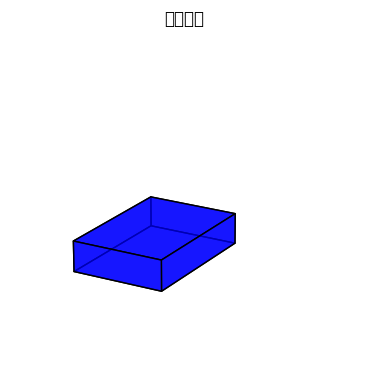

/tmp/ipython-input-44-3611680703.py:60: UserWarning:

Glyph 52841 (\N{HANGUL SYLLABLE CIB}) missing from font(s) DejaVu Sans.

/tmp/ipython-input-44-3611680703.py:60: UserWarning:

Glyph 53216 (\N{HANGUL SYLLABLE KU}) missing from font(s) DejaVu Sans.

/tmp/ipython-input-44-3611680703.py:60: UserWarning:

Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.



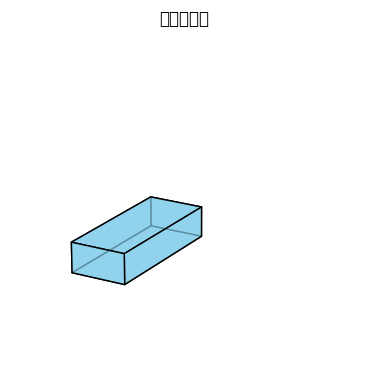

/tmp/ipython-input-44-3611680703.py:60: UserWarning:

Glyph 50556 (\N{HANGUL SYLLABLE YA}) missing from font(s) DejaVu Sans.

/tmp/ipython-input-44-3611680703.py:60: UserWarning:

Glyph 52292 (\N{HANGUL SYLLABLE CAE}) missing from font(s) DejaVu Sans.

/tmp/ipython-input-44-3611680703.py:60: UserWarning:

Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.

/tmp/ipython-input-44-3611680703.py:60: UserWarning:

Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.

/tmp/ipython-input-44-3611680703.py:60: UserWarning:

Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from font(s) DejaVu Sans.



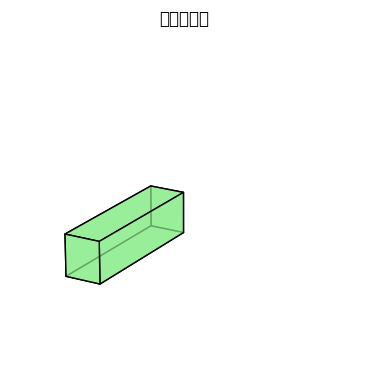

/tmp/ipython-input-44-3611680703.py:60: UserWarning:

Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.

/tmp/ipython-input-44-3611680703.py:60: UserWarning:

Glyph 50868 (\N{HANGUL SYLLABLE UN}) missing from font(s) DejaVu Sans.

/tmp/ipython-input-44-3611680703.py:60: UserWarning:

Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.

/tmp/ipython-input-44-3611680703.py:60: UserWarning:

Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.



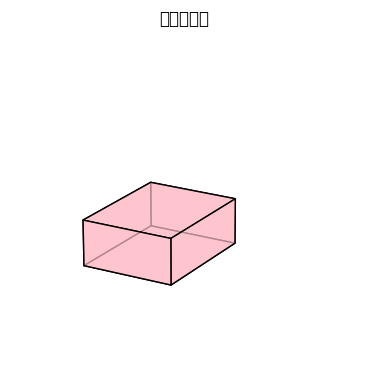

/tmp/ipython-input-44-3611680703.py:60: UserWarning:

Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.

/tmp/ipython-input-44-3611680703.py:60: UserWarning:

Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.

/tmp/ipython-input-44-3611680703.py:60: UserWarning:

Glyph 50416 (\N{HANGUL SYLLABLE SSEU}) missing from font(s) DejaVu Sans.



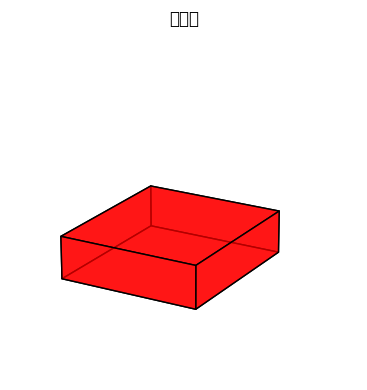

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def draw_cuboid(ax, dx, dy, dz, xlim, ylim, zlim, color):
    # 축 범위 고정
    ax.set_xlim(0, xlim)
    ax.set_ylim(0, ylim)
    ax.set_zlim(0, zlim)

    # 꼭짓점 정의
    verts = [
        (0,   0,   0),
        (dx,  0,   0),
        (dx,  dy,  0),
        (0,   dy,  0),
        (0,   0,   dz),
        (dx,  0,   dz),
        (dx,  dy,  dz),
        (0,   dy,  dz),
    ]
    # 면 정의
    faces = [
        [verts[i] for i in [0,1,2,3]],
        [verts[i] for i in [4,5,6,7]],
        [verts[i] for i in [0,1,5,4]],
        [verts[i] for i in [1,2,6,5]],
        [verts[i] for i in [2,3,7,6]],
        [verts[i] for i in [3,0,4,7]],
    ]
    # 그리기 (지정된 색상)
    pc = Poly3DCollection(faces, facecolors=color, edgecolors='black', alpha=0.7)
    ax.add_collection3d(pc)

    # 축·그리드 제거
    ax.set_axis_off()
    ax.grid(False)

# 과자별 크기와 색상 지정
snacks = {
    "초코하임":   {"size": (20.5, 14.0, 4.0), "color": "blue"},
    "초코칩쿠키": {"size": (21.0,  8.5, 4.0), "color": "skyblue"},
    "야채크래커": {"size": (22.5,  5.5, 5.5), "color": "lightgreen"},
    "크라운산도": {"size": (18.0, 14.0, 6.0), "color": "pink"},
    "오예쓰":     {"size": (23.5, 21.0, 5.5), "color": "red"},
}

# 고정 축 범위
X_MAX, Y_MAX, Z_MAX = 30, 30, 20

for name, props in snacks.items():
    dx, dy, dz = props["size"]
    color = props["color"]

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d')
    draw_cuboid(ax, dx, dy, dz, X_MAX, Y_MAX, Z_MAX, color)

    ax.view_init(elev=20, azim=30)
    ax.set_title(name, color='black')
    plt.tight_layout()
    plt.show()


In [ ]:
# ==================== 라이브러리 ====================
# HTML 다운로드용 코드
from ortools.sat.python import cp_model
from itertools import permutations
import plotly.graph_objects as go
import matplotlib.colors as mcolors
import math

# ==================== 1. 상자 정의 (mm) ====================
boxes = [
    {"name": "1-1호", "size": (165, 110,  50), "price":  600},
    {"name": "1호",   "size": (220, 190,  90), "price":  700},
    {"name": "2호",   "size": (270, 180, 150), "price":  800},
    {"name": "2-1호", "size": (350, 250, 100), "price":  900},
    {"name": "3호",   "size": (340, 250, 210), "price": 1100},
    {"name": "4호",   "size": (410, 310, 280), "price": 1700},
    {"name": "5호",   "size": (480, 360, 340), "price": 2300},
]

# ==================== 2. 아이템 정의 (cm→버림→mm) ====================
raw_cm = [
    ("초코하임",   20.5, 14.0,  4.0),
    ("초코칩쿠키", 21.0,  8.5,  4.0),
    ("야채크래커", 22.5,  5.5,  5.5),
    ("크라운산도", 18.0, 14.0,  6.0),
    ("오예쓰",     23.5, 21.0,  5.5),
]
items = []
for name, x_cm, y_cm, z_cm in raw_cm:
    x_mm = math.floor(x_cm) * 10
    y_mm = math.floor(y_cm) * 10
    z_mm = math.floor(z_cm) * 10
    items.append({"name": name, "size": (x_mm, y_mm, z_mm)})

# ==================== 3. CP-SAT Packing ====================
def solve_cp_sat_packing(box_size, items, time_limit=10):
    W, D, H = box_size
    n = len(items)
    model = cp_model.CpModel()

    x   = [model.NewIntVar(0, W, f'x{i}')    for i in range(n)]
    y   = [model.NewIntVar(0, D, f'y{i}')    for i in range(n)]
    z   = [model.NewIntVar(0, H, f'z{i}')    for i in range(n)]
    o   = [model.NewIntVar(0, 5, f'o{i}')    for i in range(n)]
    inc = [model.NewBoolVar(f'inc{i}')       for i in range(n)]

    # 6가지 회전
    oris = []
    for it in items:
        perms = list(dict.fromkeys(permutations(it["size"], 3)))
        while len(perms) < 6:
            perms.append(perms[-1])
        oris.append(perms)

    wv, dv, hv = [], [], []
    for i in range(n):
        w_i = model.NewIntVar(0, W, f'w{i}')
        d_i = model.NewIntVar(0, D, f'd{i}')
        h_i = model.NewIntVar(0, H, f'h{i}')
        allowed = [(r, *oris[i][r]) for r in range(6)]
        model.AddAllowedAssignments([o[i], w_i, d_i, h_i], allowed)
        wv.append(w_i); dv.append(d_i); hv.append(h_i)

    # 경계
    for i in range(n):
        model.Add(x[i] + wv[i] <= W).OnlyEnforceIf(inc[i])
        model.Add(y[i] + dv[i] <= D).OnlyEnforceIf(inc[i])
        model.Add(z[i] + hv[i] <= H).OnlyEnforceIf(inc[i])

    # 비중첩
    for i in range(n):
        for j in range(i+1, n):
            b = [model.NewBoolVar(f'b_{i}_{j}_{k}') for k in range(6)]
            model.Add(x[i] + wv[i] <= x[j]).OnlyEnforceIf([inc[i], inc[j], b[0]])
            model.Add(x[j] + wv[j] <= x[i]).OnlyEnforceIf([inc[i], inc[j], b[1]])
            model.Add(y[i] + dv[i] <= y[j]).OnlyEnforceIf([inc[i], inc[j], b[2]])
            model.Add(y[j] + dv[j] <= y[i]).OnlyEnforceIf([inc[i], inc[j], b[3]])
            model.Add(z[i] + hv[i] <= z[j]).OnlyEnforceIf([inc[i], inc[j], b[4]])
            model.Add(z[j] + hv[j] <= z[i]).OnlyEnforceIf([inc[i], inc[j], b[5]])
            model.AddBoolOr(b).OnlyEnforceIf([inc[i], inc[j]])

    # Full-support (바닥/다른 아이템 위에만)
    for i in range(n):
        g = model.NewBoolVar(f'sup_{i}_floor')
        model.Add(z[i] == 0).OnlyEnforceIf(g)
        model.Add(g <= inc[i])
        sup_vars = [g]
        for j in range(n):
            if i == j: continue
            s = model.NewBoolVar(f'sup_{i}_{j}')
            sup_vars.append(s)
            model.Add(s <= inc[i])
            model.Add(s <= inc[j])
            model.Add(z[i] == z[j] + hv[j]).OnlyEnforceIf(s)
            model.Add(x[i]   >= x[j]).OnlyEnforceIf(s)
            model.Add(x[i]+wv[i] <= x[j]+wv[j]).OnlyEnforceIf(s)
            model.Add(y[i]   >= y[j]).OnlyEnforceIf(s)
            model.Add(y[i]+dv[i] <= y[j]+dv[j]).OnlyEnforceIf(s)
        model.Add(sum(sup_vars) == inc[i])

    # 목표: 최대 아이템 수
    model.Maximize(sum(inc))

    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = time_limit
    status = solver.Solve(model)

    packed = []
    if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        for i in range(n):
            if solver.Value(inc[i]):
                r = solver.Value(o[i])
                packed.append({
                    "name":     items[i]["name"],
                    "size":     oris[i][r],
                    "position": (solver.Value(x[i]), solver.Value(y[i]), solver.Value(z[i]))
                })
    return packed

# ==================== 4. 3D 시각화(HTML 저장 지원) ====================
def draw_3d_plotly(box_size, packed_items, title="", filename=None):
    W, D, H = box_size
    # 사각형 Mesh3d 인덱스
    I = [0,0,1,1,2,2,3,3,4,4,5,5]
    J = [1,3,2,5,3,6,0,7,5,7,6,4]
    K = [2,2,6,6,7,7,4,4,1,3,2,0]

    allc = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
    def lum(c): return sum(w*x for w,x in zip((0.21,0.72,0.07), mcolors.to_rgb(c)))
    pal = [c for c in allc if lum(c) < 0.8]

    fig = go.Figure()
    # 1) 컨테이너
    container_verts = [
        [0, 0, 0], [W, 0, 0], [W, D, 0], [0, D, 0],
        [0, 0, H], [W, 0, H], [W, D, H], [0, D, H]
    ]
    x_c, y_c, z_c = zip(*container_verts)
    fig.add_trace(go.Mesh3d(
        x=x_c, y=y_c, z=z_c,
        i=I, j=J, k=K,
        color="lightgray",
        opacity=0.1,
        flatshading=True,
        showscale=False,
        name="Container",
        showlegend=True
    ))
    # 2) 아이템
    for idx, it in enumerate(packed_items):
        x0, y0, z0 = it["position"]
        dx, dy, dz = it["size"]
        verts = [
            [x0,     y0,     z0],     [x0+dx,  y0,     z0],
            [x0+dx,  y0+dy,  z0],     [x0,     y0+dy,  z0],
            [x0,     y0,     z0+dz],  [x0+dx,  y0,     z0+dz],
            [x0+dx,  y0+dy,  z0+dz],  [x0,     y0+dy,  z0+dz],
        ]
        xs, ys, zs = zip(*verts)
        fig.add_trace(go.Mesh3d(
            x=xs, y=ys, z=zs,
            i=I, j=J, k=K,
            color=pal[idx % len(pal)],
            opacity=0.7,
            flatshading=True,
            showscale=False,
            name=it["name"],
            showlegend=True
        ))

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(range=[0, W], title=f"X (0–{W}mm)"),
            yaxis=dict(range=[0, D], title=f"Y (0–{D}mm)"),
            zaxis=dict(range=[0, H], title=f"Z (0–{H}mm)"),
            aspectmode="data"
        ),
        legend=dict(
            title="Objects",
            orientation="h",
            yanchor="bottom", y=1.02,
            xanchor="center",  x=1
        ),
        margin=dict(l=0, r=0, b=0, t=30)
    )

    if filename is not None:
        fig.write_html(filename)
        print(f"저장됨: {filename}")
    else:
        fig.show()

# ==================== 5. 실행: 가장 작은 박스부터 ====================
def try_packing_and_save():
    for box in boxes:
        packed = solve_cp_sat_packing(box["size"], items)
        if len(packed) == len(items):
            print(f"✅ {box['name']}에 5개 모두 배치 성공!")
            fname = f"packing_{box['name']}.html"
            draw_3d_plotly(box["size"], packed, title=f"{box['name']} Packing", filename=fname)
            break
    else:
        print("❌ 어떤 박스에도 5개 아이템을 모두 넣지 못했습니다.")

if __name__ == "__main__":
    try_packing_and_save()


✅ 2-1호에 5개 모두 배치 성공!
저장됨: packing_2-1호.html


In [ ]:
from ortools.sat.python import cp_model
from itertools import permutations
import plotly.graph_objects as go
import matplotlib.colors as mcolors

# 1) 상자 정의 (mm 단위)
BOXES = {
    "3호": (340, 250, 210),
    "4호": (410, 310, 280),
    "5호": (480, 360, 340),
}
BOX_VOL = {k: v[0]*v[1]*v[2] for k,v in BOXES.items()}

def solve_pack(box_size, items, time_limit=10):
    W,D,H = box_size
    n = len(items)
    model = cp_model.CpModel()

    x = [model.NewIntVar(0, W, f'x{i}')    for i in range(n)]
    y = [model.NewIntVar(0, D, f'y{i}')    for i in range(n)]
    z = [model.NewIntVar(0, H, f'z{i}')    for i in range(n)]
    o = [model.NewIntVar(0, 5, f'o{i}')    for i in range(n)]
    inc = [model.NewBoolVar(   f'inc{i}') for i in range(n)]

    oris = []
    for it in items:
        s = list(dict.fromkeys(permutations(it["size"],3)))
        while len(s)<6: s.append(s[-1])
        oris.append(s)

    wv,dv,hv = [],[],[]
    for i in range(n):
        w_i = model.NewIntVar(0,W,f'w{i}')
        d_i = model.NewIntVar(0,D,f'd{i}')
        h_i = model.NewIntVar(0,H,f'h{i}')
        allowed = [(r,*oris[i][r]) for r in range(6)]
        model.AddAllowedAssignments([o[i],w_i,d_i,h_i], allowed)
        wv.append(w_i); dv.append(d_i); hv.append(h_i)

    for i in range(n):
        model.Add(x[i]+wv[i] <= W).OnlyEnforceIf(inc[i])
        model.Add(y[i]+dv[i] <= D).OnlyEnforceIf(inc[i])
        model.Add(z[i]+hv[i] <= H).OnlyEnforceIf(inc[i])

    for i in range(n):
        for j in range(i+1,n):
            b = [model.NewBoolVar(f'b_{i}_{j}_{k}') for k in range(6)]
            model.Add(x[i]+wv[i] <= x[j]).OnlyEnforceIf([inc[i],inc[j],b[0]])
            model.Add(x[j]+wv[j] <= x[i]).OnlyEnforceIf([inc[i],inc[j],b[1]])
            model.Add(y[i]+dv[i] <= y[j]).OnlyEnforceIf([inc[i],inc[j],b[2]])
            model.Add(y[j]+dv[j] <= y[i]).OnlyEnforceIf([inc[i],inc[j],b[3]])
            model.Add(z[i]+hv[i] <= z[j]).OnlyEnforceIf([inc[i],inc[j],b[4]])
            model.Add(z[j]+hv[j] <= z[i]).OnlyEnforceIf([inc[i],inc[j],b[5]])
            model.AddBoolOr(b).OnlyEnforceIf([inc[i],inc[j]])

    sup = {}
    for i in range(n):
        ground = model.NewBoolVar(f'sup_{i}_ground')
        sup[(i,-1)] = ground
        model.Add(z[i]==0).OnlyEnforceIf(ground)
        for j in range(n):
            if i==j: continue
            sij = model.NewBoolVar(f'sup_{i}_{j}')
            sup[(i,j)] = sij
            model.AddImplication(sij, inc[i])
            model.AddImplication(sij, inc[j])
            model.Add(z[i] == z[j] + hv[j]).OnlyEnforceIf(sij)
            model.Add(x[i]   >= x[j]).OnlyEnforceIf(sij)
            model.Add(x[i]+wv[i] <= x[j]+wv[j]).OnlyEnforceIf(sij)
            model.Add(y[i]   >= y[j]).OnlyEnforceIf(sij)
            model.Add(y[i]+dv[i] <= y[j]+dv[j]).OnlyEnforceIf(sij)
        model.Add(
            sum(sup[(i,k)] for k in [-1,*range(n)] if k!=i) == inc[i]
        )

    model.Maximize(sum(inc))

    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = time_limit
    status = solver.Solve(model)

    packed, leftover = [], []
    if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        for i in range(n):
            if solver.Value(inc[i]):
                r = solver.Value(o[i])
                packed.append({
                    "name": items[i]["name"],
                    "size": oris[i][r],
                    "position": (
                        solver.Value(x[i]),
                        solver.Value(y[i]),
                        solver.Value(z[i])
                    )
                })
            else:
                leftover.append(items[i])
    else:
        leftover = items[:]
    return packed, leftover

def get_fig(box_size, packed, title):
    W,D,H = box_size
    I=[0,0,1,1,2,2,3,3,4,4,5,5]
    J=[1,3,2,5,3,6,0,7,5,7,6,4]
    K=[2,2,6,6,7,7,4,4,1,3,2,0]
    allc = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
    lum = lambda c: sum(w*ch for w,ch in zip((0.2126,0.7152,0.0722), mcolors.to_rgb(c)))
    pal = [c for c in allc if lum(c)<=0.8]
    fig = go.Figure()
    for idx,it in enumerate(packed):
        x0,y0,z0 = it["position"]
        dx,dy,dz = it["size"]
        V = [
            [x0,y0,z0],[x0+dx,y0,z0],[x0+dx,y0+dy,z0],[x0,y0+dy,z0],
            [x0,y0,z0+dz],[x0+dx,y0,z0+dz],[x0+dx,y0+dy,z0+dz],[x0,y0+dy,z0+dz]
        ]
        xs,ys,zs = zip(*V)
        fig.add_trace(go.Mesh3d(
            x=xs,y=ys,z=zs,i=I,j=J,k=K,
            color=pal[idx%len(pal)],opacity=0.7,flatshading=True,showscale=False,
            name=it["name"]
        ))
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(range=[0,W],title=f"X 0–{W}"),
            yaxis=dict(range=[0,D],title=f"Y 0–{D}"),
            zaxis=dict(range=[0,H],title=f"Z 0–{H}"),
            aspectmode="data"
        ),
        margin=dict(l=0,r=0,b=0,t=30)
    )
    return fig

if __name__=="__main__":
    raw_cm = [
        (12,14,13),(12,8,13),(12,8,13),(10,6,13),(14,6,13),
        (8,14,13),(10,8,13),(10,8,13),(12,12,13),(12,8,13),
        (4,20,13),(14,18,13),(18,8,13),(10,12,13),(10,10,13),
        (8,20,13),(16,10,13),(12,14,13),(12,8,13),(12,8,13),
        (10,6,13),(14,6,13),(8,14,13),(10,8,13),(10,8,13),
        (12,12,13),(12,8,13),(4,20,13),(14,18,13),(18,8,13),
        (10,12,13),(10,10,13),(8,20,13),(16,10,13)
    ]
    items = [
        {"name":f"Item{i+1}", "size":(x*10,y*10,z*10)}
        for i,(x,y,z) in enumerate(raw_cm)
    ]

    cases = [("4호","4호"),("3호","5호")]
    figs = []
    for idx,(b1,b2) in enumerate(cases,1):
        p1, rem1 = solve_pack(BOXES[b1], items)
        figs.append(get_fig(BOXES[b1], p1, f"{b1} (1st)"))
        p2, rem2 = solve_pack(BOXES[b2], rem1)
        figs.append(get_fig(BOXES[b2], p2, f"{b2} (2nd)"))

    # 4개 그래프를 하나의 HTML 파일에 합쳐서 저장
    htmls = []
    for i,fig in enumerate(figs,1):
        htmls.append(fig.to_html(full_html=False, include_plotlyjs='cdn', auto_play=False,
                                 default_width='900px', default_height='650px'))
    html_final = """
    <html>
    <head><title>3D Packing Results</title></head>
    <body>
    <h2>3D Packing Results (All Cases)</h2>
    {}
    </body>
    </html>
    """.format("<hr>".join(htmls))
    with open("packing_result.html","w",encoding="utf-8") as f:
        f.write(html_final)
    print("✅ Saved: packing_result.html")


✅ Saved: packing_result.html


100%|██████████| 31/31 [10:56<00:00, 21.16s/it]
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 54840 (\N{HANGUL SYLLABLE HO}) missing from font(s) DejaVu Sans.



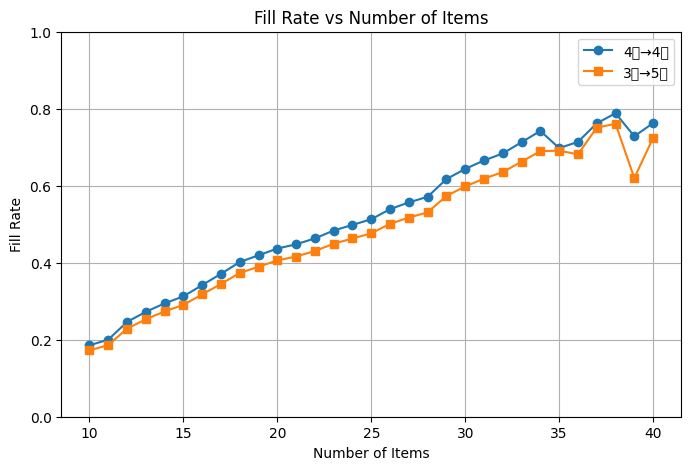

In [ ]:
from ortools.sat.python import cp_model
from itertools import permutations
import plotly.graph_objects as go
import matplotlib.colors as mcolors

# ----- [1] 상자 정의 -----
BOXES = {
    "3호": (340, 250, 210),
    "4호": (410, 310, 280),
    "5호": (480, 360, 340),
}
BOX_VOL = {k: v[0]*v[1]*v[2] for k,v in BOXES.items()}

# ----- [2] CP-SAT 3D packing 함수 (full-support) -----
def solve_pack(box_size, items, time_limit=10):
    W,D,H = box_size
    n = len(items)
    model = cp_model.CpModel()

    x = [model.NewIntVar(0, W, f'x{i}')    for i in range(n)]
    y = [model.NewIntVar(0, D, f'y{i}')    for i in range(n)]
    z = [model.NewIntVar(0, H, f'z{i}')    for i in range(n)]
    o = [model.NewIntVar(0, 5, f'o{i}')    for i in range(n)]
    inc = [model.NewBoolVar(   f'inc{i}') for i in range(n)]

    # 6가지 회전 준비
    oris = []
    for it in items:
        s = list(dict.fromkeys(permutations(it["size"],3)))
        while len(s)<6: s.append(s[-1])
        oris.append(s)

    wv,dv,hv = [],[],[]
    for i in range(n):
        w_i = model.NewIntVar(0,W,f'w{i}')
        d_i = model.NewIntVar(0,D,f'd{i}')
        h_i = model.NewIntVar(0,H,f'h{i}')
        allowed = [(r,*oris[i][r]) for r in range(6)]
        model.AddAllowedAssignments([o[i],w_i,d_i,h_i], allowed)
        wv.append(w_i); dv.append(d_i); hv.append(h_i)

    # 경계 제약
    for i in range(n):
        model.Add(x[i]+wv[i] <= W).OnlyEnforceIf(inc[i])
        model.Add(y[i]+dv[i] <= D).OnlyEnforceIf(inc[i])
        model.Add(z[i]+hv[i] <= H).OnlyEnforceIf(inc[i])

    # 비중첩 제약
    for i in range(n):
        for j in range(i+1,n):
            b = [model.NewBoolVar(f'b_{i}_{j}_{k}') for k in range(6)]
            model.Add(x[i]+wv[i] <= x[j]).OnlyEnforceIf([inc[i],inc[j],b[0]])
            model.Add(x[j]+wv[j] <= x[i]).OnlyEnforceIf([inc[i],inc[j],b[1]])
            model.Add(y[i]+dv[i] <= y[j]).OnlyEnforceIf([inc[i],inc[j],b[2]])
            model.Add(y[j]+dv[j] <= y[i]).OnlyEnforceIf([inc[i],inc[j],b[3]])
            model.Add(z[i]+hv[i] <= z[j]).OnlyEnforceIf([inc[i],inc[j],b[4]])
            model.Add(z[j]+hv[j] <= z[i]).OnlyEnforceIf([inc[i],inc[j],b[5]])
            model.AddBoolOr(b).OnlyEnforceIf([inc[i],inc[j]])

    # full-support 제약
    sup = {}
    for i in range(n):
        ground = model.NewBoolVar(f'sup_{i}_ground')
        sup[(i,-1)] = ground
        model.Add(z[i]==0).OnlyEnforceIf(ground)
        for j in range(n):
            if i==j: continue
            sij = model.NewBoolVar(f'sup_{i}_{j}')
            sup[(i,j)] = sij
            model.AddImplication(sij, inc[i])
            model.AddImplication(sij, inc[j])
            model.Add(z[i] == z[j] + hv[j]).OnlyEnforceIf(sij)
            model.Add(x[i]   >= x[j]).OnlyEnforceIf(sij)
            model.Add(x[i]+wv[i] <= x[j]+wv[j]).OnlyEnforceIf(sij)
            model.Add(y[i]   >= y[j]).OnlyEnforceIf(sij)
            model.Add(y[i]+dv[i] <= y[j]+dv[j]).OnlyEnforceIf(sij)
        model.Add(
            sum(sup[(i,k)] for k in [-1,*range(n)] if k!=i) == inc[i]
        )

    model.Maximize(sum(inc))

    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = time_limit
    status = solver.Solve(model)

    packed, leftover = [], []
    if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        for i in range(n):
            if solver.Value(inc[i]):
                r = solver.Value(o[i])
                packed.append({
                    "name": items[i]["name"],
                    "size": oris[i][r],
                    "position": (
                        solver.Value(x[i]),
                        solver.Value(y[i]),
                        solver.Value(z[i])
                    )
                })
            else:
                leftover.append(items[i])
    else:
        leftover = items[:]
    return packed, leftover

# ----- [3] 아이템 샘플 (cm단위 → mm) -----
raw_cm = [
    (12,14,13),(12,8,13),(12,8,13),(10,6,13),(14,6,13),
    (8,14,13),(10,8,13),(10,8,13),(12,12,13),(12,8,13),
    (4,20,13),(14,18,13),(18,8,13),(10,12,13),(10,10,13),
    (8,20,13),(16,10,13),(12,14,13),(12,8,13),(12,8,13),
    (10,6,13),(14,6,13),(8,14,13),(10,8,13),(10,8,13),
    (12,12,13),(12,8,13),(4,20,13),(14,18,13),(18,8,13),
    (10,12,13),(10,10,13),(8,20,13),(16,10,13),(12,14,13),(12,8,13),
    (12,8,13),(10,6,13),(14,6,13),(8,14,13),(10,8,13)
]
items_all = [
    {"name":f"Item{i+1}", "size":(x*10,y*10,z*10)}
    for i,(x,y,z) in enumerate(raw_cm)
]

# ----- [4] 케이스 fill rate 계산 -----
import tqdm

N_range = range(10, 41, 1)   # 10개~40개까지 step=1, 느릴 때 step=5
results = {"3호→5호":[], "4호→4호":[]}

for N in tqdm.tqdm(N_range):
    items = items_all[:N]

    # CASE 1: 4호→4호
    p1, rem1 = solve_pack(BOXES["4호"], items)
    p2, rem2 = solve_pack(BOXES["4호"], rem1)
    vol = sum(dx*dy*dz for it in (*p1,*p2) for dx,dy,dz in [it["size"]])
    denom = 2*BOX_VOL["4호"]
    results["4호→4호"].append(vol/denom)

    # CASE 2: 3호→5호
    p1, rem1 = solve_pack(BOXES["3호"], items)
    p2, rem2 = solve_pack(BOXES["5호"], rem1)
    vol = sum(dx*dy*dz for it in (*p1,*p2) for dx,dy,dz in [it["size"]])
    denom = BOX_VOL["3호"] + BOX_VOL["5호"]
    results["3호→5호"].append(vol/denom)

# ----- [5] 꺾은선 그래프 -----
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(N_range, results["4호→4호"], marker="o", label="4호→4호")
plt.plot(N_range, results["3호→5호"], marker="s", label="3호→5호")
plt.xlabel("Number of Items")
plt.ylabel("Fill Rate")
plt.title("Fill Rate vs Number of Items")
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()
